In [14]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sigmoid, Softmax
from torch.optim import Adam
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import time
from ptflops import get_model_complexity_info
from thop import profile

In [2]:
import numpy as np

In [3]:
import cv2

In [4]:
def read_image(file):
    feat, label = [], []
    with open(file) as f:
        for i in f:
            img_info = i.split(" ")
            
            img_name = img_info[0]
            img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32,32))
            img_feat = img / 255.0
            img_feat = np.expand_dims(img_feat, axis=0)
            feat.append(img_feat)
            
            img_label = int(img_info[-1])
            onehot = np.zeros(50)
            onehot[img_label] = 1
            label.append(onehot)
            
        return np.array(feat), np.array(label)
            

In [5]:
%%time
train_img, train_label = read_image("train.txt")
val_img, val_label = read_image("val.txt")
test_img, test_label = read_image("test.txt")

CPU times: total: 37.1 s
Wall time: 37.1 s


In [6]:
def create_dataloader(img, label, batchsize):
    feat_tensor = torch.tensor(img, dtype=torch.float32)
    label_tensor = torch.tensor(label, dtype=torch.float32)
    dataset = TensorDataset(feat_tensor, label_tensor)
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    return dataloader

In [7]:
train_dataloader = create_dataloader(train_img, train_label, batchsize=32)
val_dataloader = create_dataloader(val_img, val_label, batchsize=32)
test_dataloader = create_dataloader(test_img, test_label, batchsize=32)

# Pytorch version

In [8]:
class lenet5(nn.Module):
    def __init__(self):
        super(lenet5,self).__init__()
        self.conv1 = Conv2d(kernel_size=5, in_channels=1, out_channels=6)
        self.sigmoid1 = Sigmoid()
        self.maxpool1 = MaxPool2d(kernel_size=2)
        self.conv2 = Conv2d(kernel_size=5, in_channels=6, out_channels=16)
        self.sigmoid2 = Sigmoid()
        self.maxpool2 = MaxPool2d(kernel_size=2)
        self.flatten = Flatten()
        self.linear1 = Linear(in_features=5*5*16, out_features=120)
        self.sigmoid3 = Sigmoid()
        self.linear2 = Linear(in_features=120, out_features=84)
        self.sigmoid4 = Sigmoid()
        self.linear3 = Linear(in_features=84, out_features=50)
        self.softmax = Softmax(dim=1)
    def forward(self,x):
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.sigmoid3(x)
        x = self.linear2(x)
        x = self.sigmoid4(x)
        x = self.linear3(x)
        x = self.softmax(x)
        return x
    

In [9]:
epochs = 25
model = lenet5().to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss(reduction="sum")

In [10]:
summary(model,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 50]           4,250
          Softmax-13                   [-1, 50]               0
Total params: 65,106
Trainable params: 

In [11]:
total_train_step = 0
total_val_step = 0
best_acc_loss = 100
train_acc_epoch, train_loss_epoch = [],[]
val_acc_epoch, val_loss_epoch = [],[]

for epoch in range(epochs):
    # training
    total_train_acc = 0
    total_train_loss = 0
    
    for data in train_dataloader:
        imgs, targets = data
        imgs = imgs.to("cuda:0")
        targets = targets.to("cuda:0")

        optimizer.zero_grad()
        output = model(imgs)
        loss = loss_fn(output, targets) # a whole batch loss
        total_train_loss += loss.item()
        accuracy = (output.argmax(1) == targets.argmax(1)).sum() # top1 accuracy
        total_train_acc += accuracy.item()
        loss.backward()
        optimizer.step()

        total_train_step += 1
        if total_train_step % 100 == 0:
            print("Times of training:{}, Training Loss:{}".format(total_train_step, loss/len(targets)))
    train_acc_epoch.append(total_train_acc/len(train_dataloader.dataset))
    train_loss_epoch.append(total_train_loss/len(train_dataloader.dataset))
    # validation
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():
        for data in val_dataloader:
            imgs, targets = data
            imgs = imgs.to("cuda:0")
            targets = targets.to("cuda:0")
            output = model(imgs)
            loss = loss_fn(output, targets) # a whole batch loss
            total_val_loss += loss.item()
            val_acc = (output.argmax(1) == targets.argmax(1)).sum()
            total_val_acc += val_acc.item()

    val_acc_epoch.append(total_val_acc/len(val_dataloader.dataset))
    val_loss_epoch.append(total_val_loss/len(val_dataloader.dataset))

    if total_val_loss/len(val_dataloader.dataset) < best_acc_loss:
        best_acc_loss = total_val_loss/len(val_dataloader.dataset)
        best_weights = model.state_dict()
    print("Validation loss:{}, Validation accuracy:{}".format(total_val_loss/len(val_dataloader.dataset), total_val_acc/len(val_dataloader.dataset)))
    total_val_step += 1

torch.save(best_weights, "hw3_best_model_pytorch.pth")

Times of training:100, Training Loss:3.9115846157073975
Times of training:200, Training Loss:3.9113779067993164
Times of training:300, Training Loss:3.9114394187927246
Times of training:400, Training Loss:3.913539409637451
Times of training:500, Training Loss:3.910720109939575
Times of training:600, Training Loss:3.9127612113952637
Times of training:700, Training Loss:3.913968086242676
Times of training:800, Training Loss:3.9100522994995117
Times of training:900, Training Loss:3.9110865592956543
Times of training:1000, Training Loss:3.9142212867736816
Times of training:1100, Training Loss:3.9116454124450684
Times of training:1200, Training Loss:3.911736488342285
Times of training:1300, Training Loss:3.9153599739074707
Times of training:1400, Training Loss:3.91275954246521
Times of training:1500, Training Loss:3.9118242263793945
Times of training:1600, Training Loss:3.9114489555358887
Times of training:1700, Training Loss:3.912151336669922
Times of training:1800, Training Loss:3.9121568

In [14]:
train_acc_epoch

[0.01880773786024477,
 0.03674694038689301,
 0.05280694828266877,
 0.05651796288985393,
 0.058712988551125146,
 0.06016581129095934,
 0.06138176075799447,
 0.062360836952230554,
 0.06310303987366758,
 0.06376628503750494,
 0.06406632451638374,
 0.06586656138965653,
 0.06785629688116858,
 0.06874062376628504,
 0.06875641531780498,
 0.07049348598499802,
 0.0706987761547572,
 0.07316225819186735,
 0.07320963284642716,
 0.0732254243979471,
 0.07399921042242401,
 0.07543624161073825,
 0.07576786419265692,
 0.07693643900513225,
 0.07739439399921043]

Text(0.5, 1.0, 'Train/Validation Accuracy')

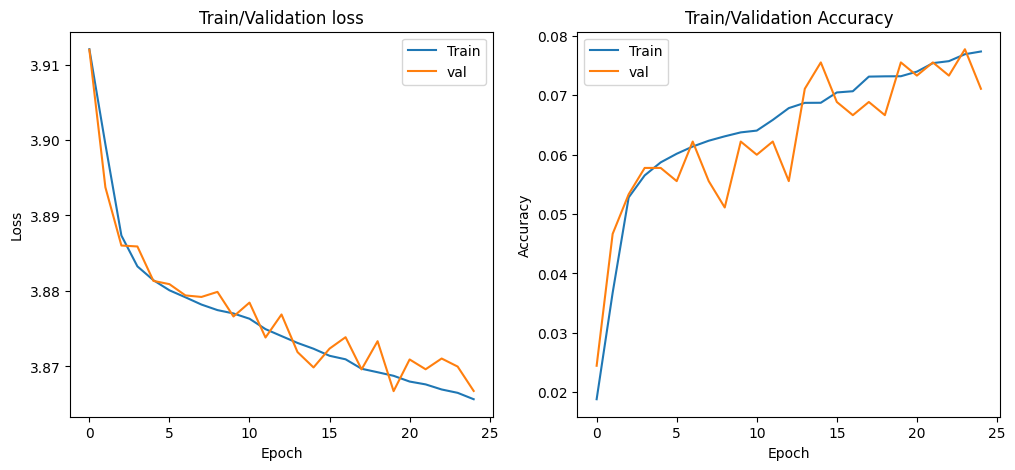

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(train_loss_epoch, label="Train")
plt.plot(val_loss_epoch, label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation loss")

plt.subplot(122)
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train/Validation Accuracy")

In [18]:
mod = lenet5()
mod.load_state_dict(torch.load("hw3_best_model_pytorch.pth"))
mod = mod.to("cuda")
total_test_acc, inference_time = 0, 0
for data in test_dataloader:
    imgs,targets = data
    imgs = imgs.to("cuda")
    targets = targets.to("cuda")

    st_time = time.perf_counter()
    output = mod(imgs)
    ed_time = time.perf_counter()
    inference_time += (ed_time - st_time)
    test_correct = (output.argmax(1) == targets.argmax(1)).sum()
    total_test_acc += test_correct
print("Test top1 accuracy:{}".format(total_test_acc/len(test_dataloader.dataset)))
print("Inference time: {}s".format(inference_time))

Test top1 accuracy:0.08666666597127914
Inference time: 0.01050059999977293s


In [16]:
# Space complexity
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(mod, (1, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

# Flops
input = torch.randn(32, 1, 32, 32).to("cuda")
macs_, params = profile(mod, inputs=(input, ))
print()
print(f"FLOPs: {macs_*2/1e6} MFLOPs, params: {params/1e6} M")

lenet5(
  65.11 k, 100.000% Params, 432.74 KMac, 100.000% MACs, 
  (conv1): Conv2d(156, 0.240% Params, 122.3 KMac, 28.263% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid1): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (maxpool1): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.087% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2.42 k, 3.711% Params, 241.6 KMac, 55.830% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sigmoid2): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (maxpool2): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.370% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (linear1): Linear(48.12 k, 73.910% Params, 48.12 KMac, 11.120% MACs, in_features=400, out_features=120, bias=True)
  (sigmoid3): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (linear2): Linear(10.16 k, 15.611% Params, 10.16 KMac, 2.349% MA